In [1]:
import albumentations
import numpy as np
from utils import *
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-27 22:38:57.181192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-27 22:39:00.016237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/odilon/.local/lib/python3.10/site-packages/cv2/../../lib64:
2025-06-27 22:39

In [2]:
use_max = True
classes = 20
model_input_shape = (224, 224)
model_feature_map_shape = tuple(np.asarray(model_input_shape) // 32)

In [3]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet")


model = create_model_with_spatial_scores(base_model, classes + 1, use_max)
# model.load_weights("weights/model_double_loss_soft_max_0.0_1.0_downsampled_slow.hdf5")
# model.load_weights("weights/model_single_loss_soft_max_downsampled.hdf5")
model.load_weights("weights/model_sal_mobile_21k_full.hdf5")

2025-06-27 22:39:03.095479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-27 22:39:03.231414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-27 22:39:03.231738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-27 22:39:03.232960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [4]:
pred_single = np.load("losses/model_softmax_scheduled_full_test_predictions.npy")
pred_double = np.load("losses/model_softmax_9010_full_test_predictions.npy")
pred_avg = np.load("losses/model_mean_full_test_predictions.npy")

In [5]:
np.sum(pred_single[0,:,15,1])

48.0

In [6]:
pred_double.shape

(19, 1710, 20, 2)

In [7]:
np.max(np.random.random((7,7)))

0.9796072571185377

In [8]:
np.mean(pred_double[0,:,:,0], axis=0)

array([0.02773795, 0.02231598, 0.01888307, 0.01421555, 0.02016528,
       0.01521941, 0.05978861, 0.05828068, 0.07602195, 0.00701772,
       0.02320829, 0.03945721, 0.01878568, 0.02051573, 0.5822741 ,
       0.00868259, 0.00827094, 0.03461052, 0.01458711, 0.01986732],
      dtype=float32)

In [9]:
pred_avg.shape

(19, 1710, 20, 2)

In [10]:
metrics_single = calculate_metrics(pred_single, cutoff=0.125)
metrics_double = calculate_metrics(pred_double, cutoff=0.125)
metrics_avg = calculate_metrics(pred_avg, cutoff=0.05)

In [11]:
# np.max(metrics_avg["accuracy"][30:])

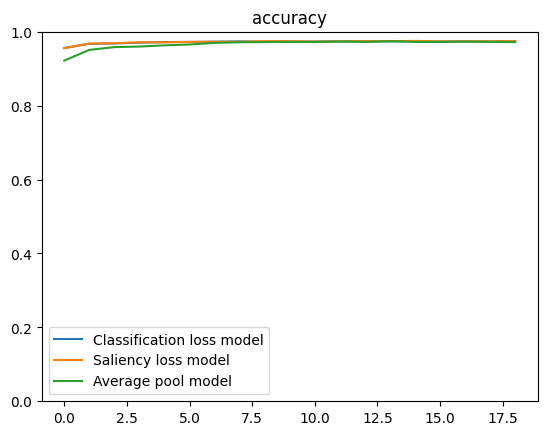

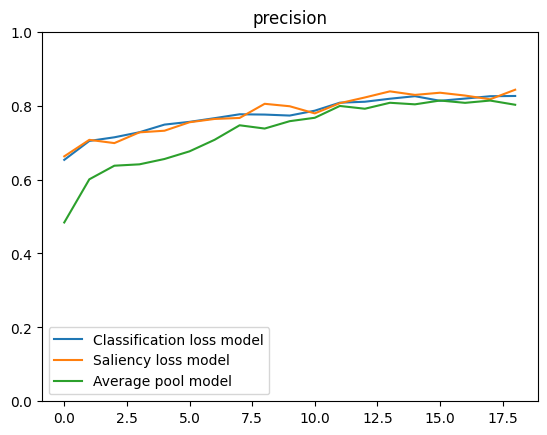

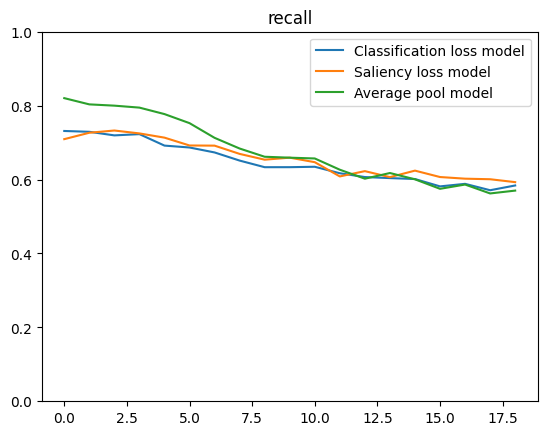

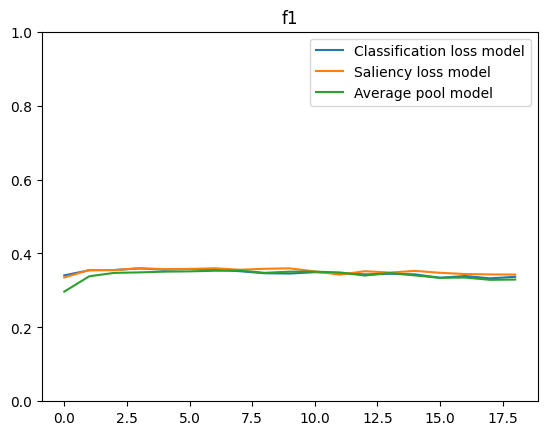

In [12]:
for key in metrics_double.keys():
    plt.plot(metrics_single[key], label="Classification loss model")
    plt.plot(metrics_double[key], label="Saliency loss model")
    plt.plot(metrics_avg[key], label="Average pool model")
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.title(key)
    plt.show()

In [13]:
def running_min(arr, init=np.inf):
    curr_min = init
    arr_new = np.zeros(arr.shape)
    for i in range(len(arr)):
        curr_min = min(curr_min, arr[i])
        arr_new[i] = curr_min
    return arr_new

In [14]:
ignore = 10

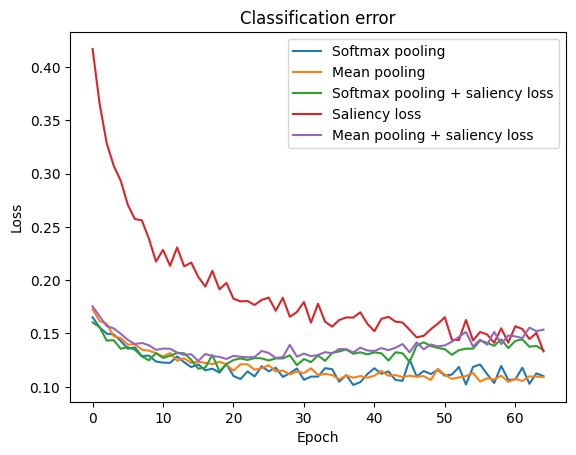

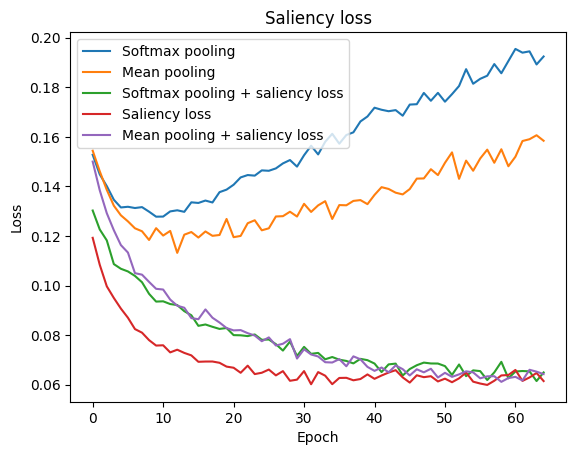

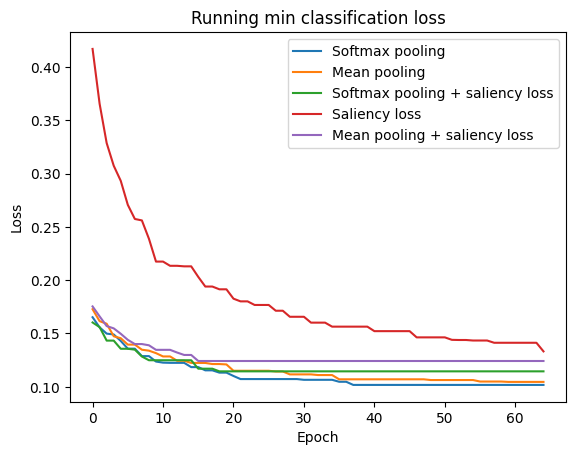

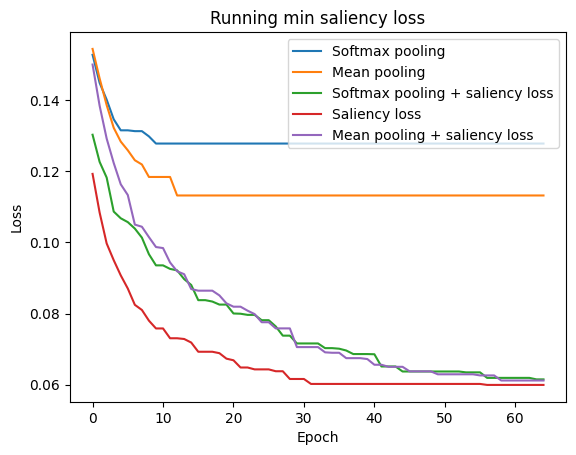

In [15]:
combined_loss_li_double, cce_loss_li_double, sal_loss_li_double = np.load("losses/model_softmax_part_class_losses.npy")

plt.plot(cce_loss_li_double[ignore:], label="Softmax pooling")

# plt.plot(combined_loss_li, label="Combined current")
# plt.legend()
# plt.show()
combined_loss_li_single, cce_loss_li_single, sal_loss_li_single = np.load("losses/model_mean_part_class_losses.npy")
plt.plot(cce_loss_li_single[ignore:], label="Mean pooling")
# plt.plot(combined_loss_li_single, label="Combined comp")
# combined_loss_li_avg, cce_loss_li_avg, sal_loss_li_avg = np.load("losses/model_mean_downsampled_slow_mobile_losses.npy")
# combined_loss_li_GeM, cce_loss_GeM, sal_loss_GeM = np.load("losses/model_5050_GeM_mobile_losses.npy")
combined_loss_li_sch, cce_loss_li_sch, sal_loss_li_sch = np.load("losses/model_softmax_part_scheduled_losses.npy")

plt.plot(cce_loss_li_sch[ignore:], label="Softmax pooling + saliency loss")


combined_loss_li_neg, cce_loss_li_neg, sal_loss_li_neg = np.load("losses/model_max_part_sal_losses.npy")

plt.plot(cce_loss_li_neg[ignore:], label="Saliency loss")

combined_loss_li_sch2, cce_loss_li_sch2, sal_loss_li_sch2 = np.load("losses/model_mean_part_scheduled_losses.npy")
plt.plot(cce_loss_li_sch2[ignore:], label="Mean pooling + saliency loss")

# combined_loss_li_05, cce_loss_li_05, sal_loss_li_05 = np.load("losses/model_0.5fixed_mobile_21k_full_losses.npy")
#
# plt.plot(cce_loss_li_05, label="CCE half half model")

# plt.plot(cce_loss_GeM, label="CCE GeM model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Classification error")
plt.show()


plt.plot(sal_loss_li_double[ignore:], label="Softmax pooling")
plt.plot(sal_loss_li_single[ignore:], label="Mean pooling")
plt.plot(sal_loss_li_sch[ignore:], label="Softmax pooling + saliency loss")
plt.plot(sal_loss_li_neg[ignore:], label="Saliency loss")
plt.plot(sal_loss_li_sch2[ignore:], label="Mean pooling + saliency loss")
# plt.plot(sal_loss_li_05, label="SAL half half model")

# plt.plot(sal_loss_GeM, label="CCE less GeM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Saliency loss")
plt.show()

plt.plot(running_min(cce_loss_li_double[ignore:]), label="Softmax pooling")
plt.plot(running_min(cce_loss_li_single[ignore:]), label="Mean pooling")
plt.plot(running_min(cce_loss_li_sch[ignore:]), label="Softmax pooling + saliency loss")
plt.plot(running_min(cce_loss_li_neg[ignore:]), label="Saliency loss")
plt.plot(running_min(cce_loss_li_sch2[ignore:]), label="Mean pooling + saliency loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Running min classification loss")
plt.show()

plt.plot(running_min(sal_loss_li_double[ignore:]), label="Softmax pooling")
plt.plot(running_min(sal_loss_li_single[ignore:]), label="Mean pooling")
plt.plot(running_min(sal_loss_li_sch[ignore:]), label="Softmax pooling + saliency loss")
plt.plot(running_min(sal_loss_li_neg[ignore:]), label="Saliency loss")
plt.plot(running_min(sal_loss_li_sch2[ignore:]), label="Mean pooling + saliency loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Running min saliency loss")
plt.show()

In [16]:
combined_loss_li_sch, cce_loss_li_sch

(array([0.56663868, 0.45255868, 0.41706787, 0.37023773, 0.31769568,
        0.27011181, 0.23330319, 0.20429168, 0.18622325, 0.16998432,
        0.15702605, 0.15195705, 0.14005485, 0.13878888, 0.1313296 ,
        0.13213857, 0.12956223, 0.1235383 , 0.11953302, 0.12397845,
        0.12008161, 0.12104637, 0.12269808, 0.12139461, 0.1160025 ,
        0.10834113, 0.10883603, 0.11682219, 0.10521855, 0.10979625,
        0.1111152 , 0.11168245, 0.11009801, 0.11106723, 0.10964762,
        0.10798418, 0.10802727, 0.10651494, 0.10918731, 0.10083532,
        0.10520602, 0.10187607, 0.10506793, 0.10051688, 0.10453195,
        0.10415608, 0.1042481 , 0.10103198, 0.10201399, 0.1001638 ,
        0.09980059, 0.0969271 , 0.09470501, 0.09791623, 0.09418579,
        0.09138071, 0.09826954, 0.09952907, 0.09715987, 0.09572799,
        0.09395308, 0.08905514, 0.09267978, 0.08948559, 0.09030202,
        0.09197096, 0.08809283, 0.08847888, 0.09256772, 0.08470922,
        0.08787544, 0.08766536, 0.08488255, 0.08

In [17]:
transform = albumentations.Compose([
    # albumentations.RandomCrop(width=224, height=224),
    albumentations.RandomCrop(width=model_input_shape[0], height=model_input_shape[1]),
    albumentations.HorizontalFlip(p=0.5),
    # albumentations.RandomBrightnessContrast(p=0.2, brightness_limit=0.1, contrast_limit=0.1),
])

In [18]:
augment_image_and_mask = make_augement_image_and_mask(transform, model_input_shape)

(387, 500, 3)
(387, 500)


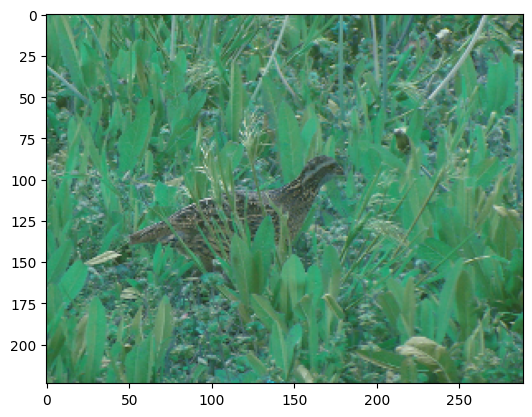

(224, 289, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999999].


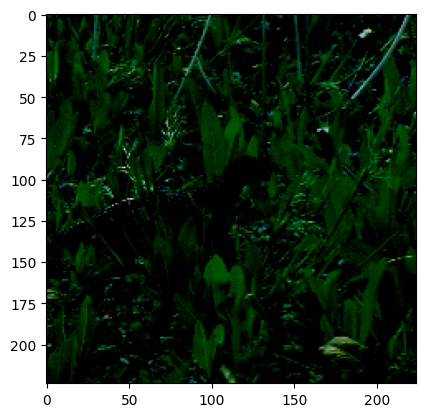

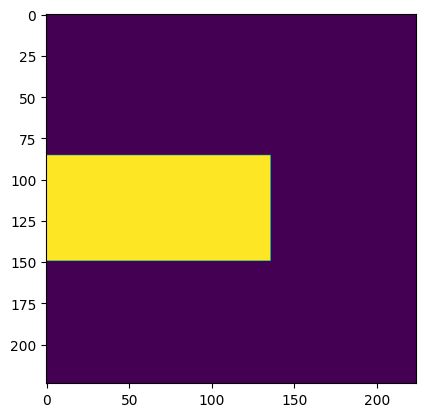

In [19]:
# img_path = '../imgs/cb1000r.jpg'
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_no = 17002
img = np.load("../../dataset/img/train_745.npy")
img = np.load(f"../../pascal/output/images/{img_no}.npy")
seg, _ = seg_from_box(np.load(f"../../pascal/output/boxes/{img_no}.npy"), img.shape, 21)
print(img.shape)
print(seg.shape)
# img = 255 - img

img_smallest_dim = np.argmin(img.shape[:2])
ratio = model_input_shape[img_smallest_dim] / img.shape[img_smallest_dim]
new_size = (ratio * np.asarray(img.shape[:2]) + 0.5).astype(int)
img = cv2.resize(img, new_size[::-1])
seg = cv2.resize(seg, new_size[::-1], interpolation=cv2.INTER_NEAREST)

plt.imshow(img)
plt.show()
print(img.shape)

# img = cv2.resize(img, (224, 224))
# img_array = np.expand_dims(img, axis=0).astype('float32') / 255.0
img, mask = augment_image_and_mask(img, seg)
plt.imshow(img)
plt.show()
plt.imshow(to_ordinal(mask))
plt.show()

In [20]:
spatial_scores, class_scores = model(np.expand_dims(img, axis=0), training=False)


2025-06-27 22:39:10.723908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400


In [21]:
class_scores.numpy()

array([[9.9956256e-01, 3.6951882e-04, 3.3254025e-03, 9.8640084e-01,
        7.5274246e-04, 7.9881551e-04, 2.7101460e-05, 2.5271266e-04,
        3.5596051e-04, 2.8505409e-03, 1.6684843e-03, 2.4646933e-03,
        2.4404782e-03, 1.0663814e-04, 1.3667815e-03, 1.8089458e-03,
        2.3998399e-01, 1.8821538e-03, 2.6420687e-04, 1.2868519e-03,
        4.7140443e-04]], dtype=float32)

In [22]:
spatial_scores = spatial_scores.numpy()

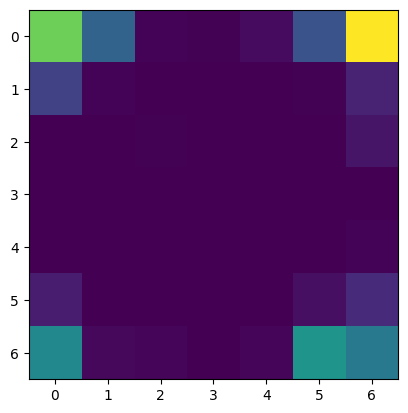

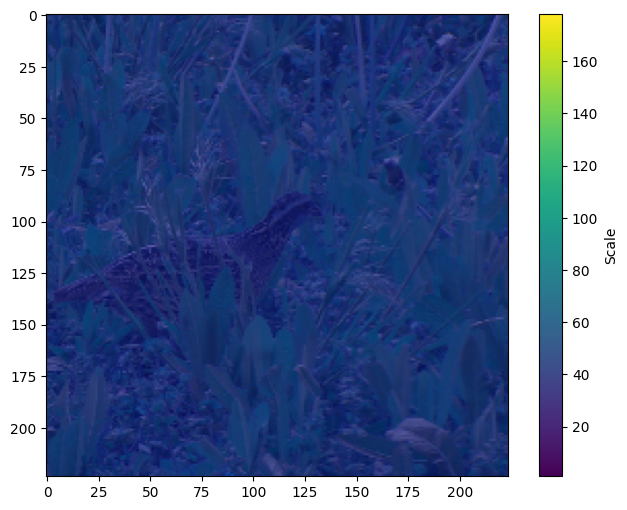

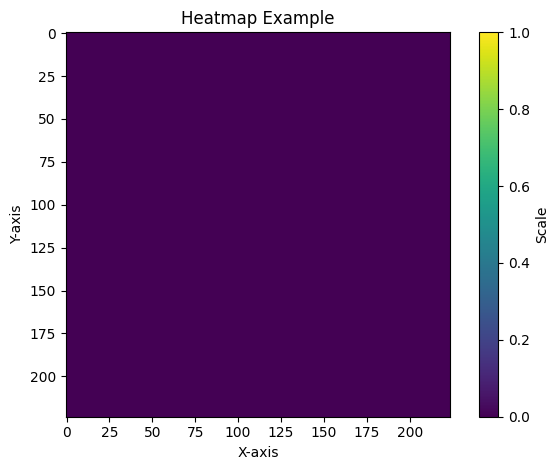

(1, 224, 224, 21)


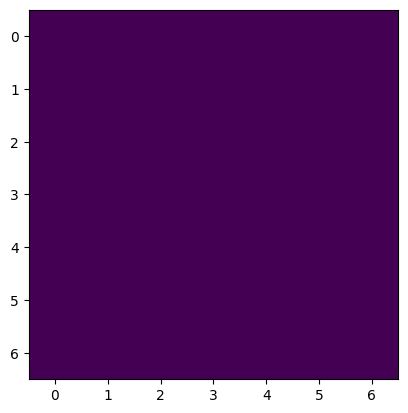

In [23]:
cls_no = 2

sp_scores_cls = spatial_scores[0][:,:,cls_no]
plt.imshow(sp_scores_cls)
plt.show()
sp_scores_cls = cv2.resize(sp_scores_cls, model_input_shape[:2], interpolation=cv2.INTER_LINEAR)
# Create the heatmap
plt.figure(figsize=(8, 6))

heatmap = sp_scores_cls
colormap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
colormap = cv2.cvtColor(colormap, cv2.COLOR_BGR2RGB)  # Convert for Matplotlib
img_unnormalized = (cv2.normalize(img.numpy(), None, 0, 1, cv2.NORM_MINMAX) * 255).astype(np.uint8)
# Blend heatmap with the image
alpha = 0.6  # Transparency factor
overlay = cv2.addWeighted(img_unnormalized, 1 - alpha, colormap, alpha, 0)
# plt.imshow(img)
heatmap = plt.imshow(overlay)
cbar = plt.colorbar(heatmap, )
cbar.set_label('Scale')
plt.show()
heatmap = plt.imshow(sp_scores_cls, vmin=0, vmax=1)
# plt.show()

# Add color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Scale')

# Annotate the heatmap
# for i in range(sp_scores_cls.shape[0]):
#     for j in range(sp_scores_cls.shape[1]):
#         plt.text(j, i, f'{round(sp_scores_cls[i, j],2)}', ha='center', va='center', color='white' if sp_scores_cls[i, j] > 50 else 'black')

# Add labels and title
plt.title('Heatmap Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show plot
plt.tight_layout()
plt.show()
print(np.expand_dims(mask, axis=0).shape)
resize_to_output_tf = make_resize_to_output_tf(model_input_shape, model_feature_map_shape)
plt.imshow(resize_to_output_tf(np.expand_dims(tf.convert_to_tensor(mask, dtype=tf.uint8), axis=0), (7, 7))[0,:,:,cls_no])